# Kickstarter Projects

In [193]:
#disable autoscrolling
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

SyntaxError: invalid syntax (<ipython-input-193-e6452eeed186>, line 3)

In [194]:
#change display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Can we predict which Kickstarter projects will be successful?

## Data Cleaning and Exploration

In [195]:
#import pandas, matplotlib, seaborn, other packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [196]:
#change the float display for when using .describe()
pd.options.display.float_format = "{:.2f}".format

In [197]:
#read in and preview file
#download path https://www.kaggle.com/toshimelonhead/400000-kickstarter-projects
file_path = 'kickstarter.csv'

data = pd.read_csv(file_path, index_col = 'Unnamed: 0')
print(data.head(1))
data.info()

          id  backers_count  \
0  857125548              1   

                                               blurb currency    goal  \
0  Exploring paint and its place in a digital world.      USD 2000.00   

           launched_at             deadline location.country   name  \
0  2015-03-19 22:34:57  2015-04-30 23:12:00               US  Remix   

   usd_pledged  ... days_to_deadline  goal_USD  category_name  category_slug  \
0        25.00  ...               42   2000.00    Digital Art            art   

  blurb_length  location_type  location_country  location_state  \
0            9           Town                US              NY   

   location_displayable_name  binary_state  
0               New York, NY        failed  

[1 rows x 29 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 430938 entries, 0 to 768
Data columns (total 29 columns):
id                           430938 non-null int64
backers_count                430938 non-null int64
blurb                       

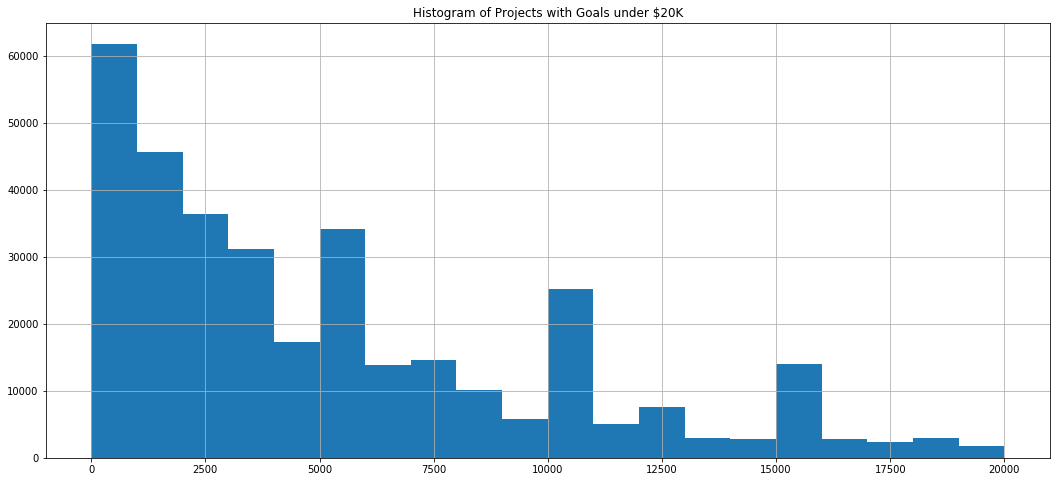

In [198]:
#attempt to understand goal_USD data shape by only looking at data under 20k
data['goal_USD'].loc[data['goal_USD'] < 20000].hist(bins = 20, figsize=(18,8))
plt.title('Histogram of Projects with Goals under $20K')
plt.show()

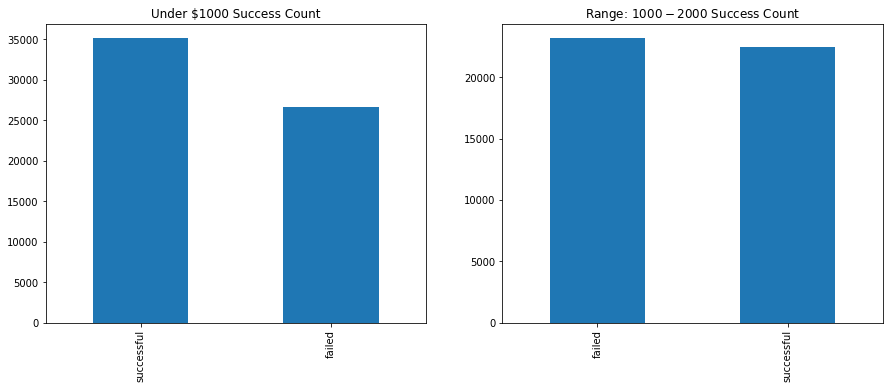

In [199]:
#Checking first 1000 category against 2nd 1000. Already by the second, failure is more likely than success.
fig=plt.figure(figsize=(15,5.5))
plt.subplot(1,2,1)
plt.title('Under $1000 Success Count')
data['binary_state'].loc[data['goal_USD'] < 1000].value_counts().plot(kind='bar')
plt.subplot(1,2,2)
plt.title("Range: $1000 - $2000 Success Count")
data['binary_state'].loc[(data['goal_USD'] >= 1000) & (data['goal_USD'] < 2000)].value_counts().plot(kind='bar')
plt.show()


I decided to throw out data with a goal under $1000 as they do not seem to be "serious" crowdfunding projects.

In [200]:
#throwing data with a goal under 1000
cleaned_data = data.loc[data['goal_USD'] >= 1000]

In [201]:
#print out approximate time when data was captured
print(cleaned_data['launched_at'].max())
#filter out data where target date is beyond the date of the data
cleaned_data = cleaned_data.loc[cleaned_data['deadline'] <= cleaned_data['launched_at'].max()]

2019-04-18 04:49:38


I threw out data where the deadline is beyond the cutoff date

## Is ID an appropriate Index?

In [202]:
#is ID an appropriate index?
cleaned_data.id.nunique()

267679

ID is not an appropriate index as there are many duplicates

In [203]:
#look at some duplicated ID values
cleaned_data[cleaned_data.id.duplicated(keep=False)].sort_values('id').head(7)

,id,backers_count,blurb,currency,goal,launched_at,deadline,location.country,name,usd_pledged,...,days_to_deadline,goal_USD,category_name,category_slug,blurb_length,location_type,location_country,location_state,location_displayable_name,binary_state
3619,8624,737,A compact outdoor cooking set that you can use...,EUR,30000.00,2018-02-22 09:44:29,2018-03-29 08:44:29,US,Kombuis a portable and efficient rocket stove ...,93005.59,...,35,36966.30,Product Design,design,12,Town,US,WV,"Belgium, WV",successful
865,8624,499,A compact outdoor cooking set that you can use...,EUR,30000.00,2018-02-22 09:44:29,2018-03-29 08:44:29,US,Kombuis a portable and efficient rocket stove ...,59989.76,...,35,36966.30,Product Design,design,12,Town,US,WV,"Belgium, WV",successful
1446,8624,498,A compact outdoor cooking set that you can use...,EUR,30000.00,2018-02-22 09:44:29,2018-03-29 08:44:29,US,Kombuis a portable and efficient rocket stove ...,59871.47,...,35,36966.30,Product Design,design,12,Town,US,WV,"Belgium, WV",successful
2753,18520,2,Raising money to help my grandmother recover f...,USD,15000.00,2016-10-19 13:32:40,2016-11-18 14:32:40,US,Grandma's are Life,11.00,...,30,15000.00,World Music,music,24,Town,US,OH,"Cleveland, OH",failed
3348,18520,4,Raising money to help my grandmother recover f...,USD,15000.00,2016-10-19 13:32:40,2016-11-18 14:32:40,US,Grandma's are Life,62.00,...,30,15000.00,World Music,music,24,Town,US,OH,"Cleveland, OH",failed
3511,38736,3,All your herbal tea remedies here. From colds ...,USD,2500.00,2018-08-22 03:51:56,2018-10-21 03:51:56,US,Herbal Teas,96.00,...,60,2500.00,Drinks,food,21,Town,US,NY,"Livonia, NY",failed
3006,38736,3,All your herbal tea remedies here. From colds ...,USD,2500.00,2018-08-22 03:51:56,2018-10-21 03:51:56,US,Herbal Teas,96.00,...,60,2500.00,Drinks,food,21,Town,US,NY,"Livonia, NY",failed


The same projects are captured at different points in time, I will remove duplicate ID lines taking information from the most recent information (highest USD pledged)

In [204]:
#dropping duplicates, note sorting by usd pledged so I only keep the most recent data (unlikely pledged amount goes down)
cleaned_data = cleaned_data.sort_values('usd_pledged', ascending = False).drop_duplicates(subset = 'id', keep = 'first')
cleaned_data.id.describe()

count       267679.00
mean    1073459652.11
std      619440051.22
min           8624.00
25%      536011791.50
50%     1075032467.00
75%     1608601833.00
max     2147476221.00
Name: id, dtype: float64

ID is now a unique column, so it can be set as the index

In [205]:
#drop old index and replace with ID column
cleaned_data = cleaned_data.reset_index(drop=True).set_index('id').sort_index()

## Date Time Columns

In [206]:
#create a new column for days between launch and goal date
cleaned_data['launched_at'] = pd.to_datetime(cleaned_data['launched_at'])
cleaned_data['deadline'] = pd.to_datetime(cleaned_data['deadline'])
cleaned_data['days_between'] = (cleaned_data['deadline'] - cleaned_data['launched_at']).dt.days

## Creating Additional Columns

In [207]:
#create a proportion of goal column
cleaned_data['prop_goal'] = cleaned_data['usd_pledged'] / cleaned_data['goal_USD']

In [208]:
#strip out city name
cleaned_data['city'] = [i.split(', ')[0] for i in cleaned_data['location_displayable_name']]

In [209]:
#convert binary outcome to boolean
cleaned_data['outcome'] = [(i == 'successful') for i in cleaned_data['binary_state']]

In [210]:
#count the length of the name
cleaned_data['name_length'] = [len(str(i).split()) for i in cleaned_data.name]

## Looking at Text Columns (blurb and name)

In [211]:
#looking for help as the first word in the blurb
cleaned_data['help_first_blurb'] = [('help' == str(i)[0:4].lower()) for i in cleaned_data.blurb]
print(cleaned_data.help_first_blurb.value_counts())
print((cleaned_data['help_first_blurb'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['help_first_blurb'].value_counts()))

False    260978
True       6701
Name: help_first_blurb, dtype: int64
False   0.43
True    0.56
Name: help_first_blurb, dtype: float64


Highlighting the purpose of helping someone is helpful for success.

In [212]:
#looking for luxury in blurb
cleaned_data['luxury_blurb'] = ['luxury' in str(i).lower() for i in cleaned_data.blurb]
print(cleaned_data.luxury_blurb.value_counts())
print((cleaned_data['luxury_blurb'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['luxury_blurb'].value_counts()))
#luxury doesn't appear that often, so dropping it
cleaned_data.drop(['luxury_blurb'], axis = 1, inplace = True)

False    266872
True        807
Name: luxury_blurb, dtype: int64
False   0.43
True    0.40
Name: luxury_blurb, dtype: float64


Luxury did not appear often in blurb

In [213]:
#looking for family in blurb
cleaned_data['family_blurb'] = ['family' in str(i).lower() for i in cleaned_data.blurb]
print(cleaned_data.family_blurb.value_counts())
print((cleaned_data['family_blurb'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['family_blurb'].value_counts()))

#removing
cleaned_data.drop(['family_blurb'], axis = 1, inplace = True)

False    263225
True       4454
Name: family_blurb, dtype: int64
False   0.43
True    0.40
Name: family_blurb, dtype: float64


The word family in blurb was correlated with slightly less success. I decided to remove the variable

In [214]:
#check if the first word of the blurb or name is lowercase
def lowercase_first(row):
    y = ((str(row['blurb'])[0:2].islower()) and (str(row['blurb'])[0:2].isalpha()) or ((str(row['name'])[0:2].islower()) and (str(row['name'])[0:2].isalpha())))
    return y

cleaned_data['lowercase_first'] = cleaned_data.apply(lowercase_first, axis=1)

print(cleaned_data.lowercase_first.value_counts())
print((cleaned_data['lowercase_first'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['lowercase_first'].value_counts()))

False    261795
True       5884
Name: lowercase_first, dtype: int64
False   0.44
True    0.30
Name: lowercase_first, dtype: float64


Lack of capitalization might indicate informality or lack of attention to detail.

In [215]:
#check if the the first word of the name is all capitalized
cleaned_data['first_name_cap'] = [(str(i)[0:2].isupper()) and (str(i)[0:2].isalpha()) for i in cleaned_data.name]
print(cleaned_data.first_name_cap.value_counts())
print((cleaned_data['first_name_cap'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['first_name_cap'].value_counts()))

#check if the the first word of the blurb is capitalized wasn't as impactful

False    236085
True      31594
Name: first_name_cap, dtype: int64
False   0.43
True    0.49
Name: first_name_cap, dtype: float64


Those projects capitalizing the first word of the name had a slightly higher probability of success.

In [216]:
#does the blurb contain an exclamation point? Does the name?

cleaned_data['blurb_exclam'] = [("!" in str(i)) for i in cleaned_data.blurb]
print(cleaned_data.blurb_exclam.value_counts())
print((cleaned_data['blurb_exclam'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['blurb_exclam'].value_counts()))

cleaned_data['name_exclam'] = [("!" in str(i)) for i in cleaned_data.name]
print(cleaned_data.name_exclam.value_counts())
print((cleaned_data['name_exclam'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['name_exclam'].value_counts()))


False    206101
True      61578
Name: blurb_exclam, dtype: int64
False   0.42
True    0.49
Name: blurb_exclam, dtype: float64
False    243895
True      23784
Name: name_exclam, dtype: int64
False   0.43
True    0.51
Name: name_exclam, dtype: float64


## Additional Cleaning (Dropping Columns)

In [217]:
#confirm staff_pick and spotlight highly correlated with success
print("The proportion of projects that are a staff pick: " + str(round(cleaned_data.staff_pick.mean(), 3)) + ".")
print("The proportion of projects that are a staff pick successful are: " + str(round(cleaned_data.outcome.loc[cleaned_data.staff_pick == True].mean(), 3)) + ".")
print("")
print("The proportion of projects that are spotlighted: " + str(round(cleaned_data.spotlight.mean(), 3)) + ".")
print("The proportion of projects that are spotlighted and successful: " + str(round(cleaned_data.outcome.loc[cleaned_data.spotlight == True].mean(), 3)) + ".")

The proportion of projects that are a staff pick: 0.12.
The proportion of projects that are a staff pick successful are: 0.837.

The proportion of projects that are spotlighted: 0.429.
The proportion of projects that are spotlighted and successful: 1.0.


In [218]:
# dropping the location.country column (already location_country column); 
# the days to deadline not useful as the deadline should be passed;
# the state column is not necessary with the outcome column; and the individual date columns are not necessary
# the spotlight and staff pick columns can be dropped
# dropping a few additional columns I never plan to use

cleaned_data = cleaned_data.drop(columns=['location.country', 'days_to_deadline', 'state', 
                                 'year', 'month', 'day', 'hour', 'spotlight', 'staff_pick', 'location_displayable_name', 'slug'])

Dropping unnecessary columns

In [219]:
#looking at info of cleaning data
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267679 entries, 8624 to 2147476221
Data columns (total 27 columns):
backers_count       267679 non-null int64
blurb               267679 non-null object
currency            267679 non-null object
goal                267679 non-null float64
launched_at         267679 non-null datetime64[ns]
deadline            267679 non-null datetime64[ns]
name                267676 non-null object
usd_pledged         267679 non-null float64
static_usd_rate     267679 non-null float64
goal_USD            267679 non-null float64
category_name       267679 non-null object
category_slug       267679 non-null object
blurb_length        267679 non-null int64
location_type       267679 non-null object
location_country    267679 non-null object
location_state      267679 non-null object
binary_state        267679 non-null object
days_between        267679 non-null int64
prop_goal           267679 non-null float64
city                267679 non-null object
outc

In [220]:
#examining data lines for more insights on keywords
cleaned_data.head(8)

,backers_count,blurb,currency,goal,launched_at,deadline,name,usd_pledged,static_usd_rate,goal_USD,...,days_between,prop_goal,city,outcome,name_length,help_first_blurb,lowercase_first,first_name_cap,blurb_exclam,name_exclam
id,,,,,,,,,,,,,,,,,,,,,
8624,737,A compact outdoor cooking set that you can use...,EUR,30000.00,2018-02-22 09:44:29,2018-03-29 08:44:29,Kombuis a portable and efficient rocket stove ...,93005.59,1.23,36966.30,...,34,2.52,Belgium,True,10,False,False,False,False,False
18520,4,Raising money to help my grandmother recover f...,USD,15000.00,2016-10-19 13:32:40,2016-11-18 14:32:40,Grandma's are Life,62.00,1.00,15000.00,...,30,0.00,Cleveland,False,3,False,False,False,False,False
24380,18,A sanctuary for humans and felines alike! Come...,USD,20000.00,2015-10-27 15:25:33,2015-11-26 16:25:33,Puss N' Books: A relaxing cat cafe and bookstore.,776.00,1.00,20000.00,...,30,0.04,Bloomington,False,9,False,False,False,True,False
33867,42,Taste Makers is a socially conscious brand tha...,CAD,18000.00,2015-06-15 18:28:11,2015-07-30 18:28:11,TASTE MAKERS BY TRISH P,2271.72,0.81,14614.38,...,45,0.16,Vancouver,False,5,False,False,True,False,False
38736,3,All your herbal tea remedies here. From colds ...,USD,2500.00,2018-08-22 03:51:56,2018-10-21 03:51:56,Herbal Teas,96.00,1.00,2500.00,...,60,0.04,Livonia,False,2,False,False,False,False,False
39036,68,"The BEST beef sticks, beef jerky and signature...",USD,2500.00,2016-05-16 22:34:18,2016-06-30 22:34:18,The Meat Candy Experience,3239.00,1.00,2500.00,...,45,1.30,Kronenwetter,True,4,False,False,False,False,False
39235,338,"4tec is a classic 4 in a row table top game, r...",EUR,5000.00,2018-09-10 06:48:50,2018-10-10 06:48:50,4tec: a New 3D Connect 4 Game,15440.03,1.16,5781.92,...,30,2.67,Dublin,True,7,False,False,False,False,False
39409,66,CalArts thesis film inspired by true events su...,USD,10500.00,2011-07-20 19:28:17,2011-08-19 19:28:17,WHILE THE TREES SLEEP,11545.00,1.00,10500.00,...,30,1.10,Columbia,True,4,False,False,True,False,False


## Data Visualization

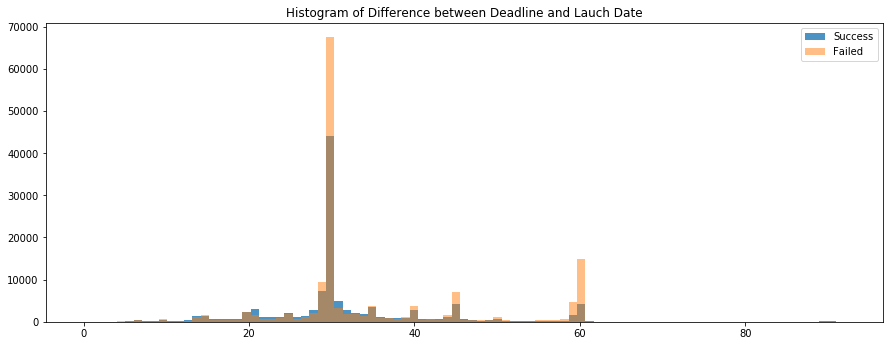

Success Descriptive Statistics
count   116077.00
mean        32.57
std         11.20
min          1.00
25%         29.00
50%         30.00
75%         34.00
max         91.00
Name: days_between, dtype: float64

Failed Descriptive Statistics
count   151602.00
mean        35.48
std         12.63
min          1.00
25%         30.00
50%         30.00
75%         40.00
max         92.00
Name: days_between, dtype: float64


In [221]:
#histogram of days between
fig=plt.figure(figsize=(15,5.5))
x = cleaned_data['days_between'].loc[cleaned_data['outcome'] == True]
y = cleaned_data['days_between'].loc[cleaned_data['outcome'] == False]
bins = np.linspace(0, 92, 92)

plt.hist(x, bins, alpha=0.8, label='Success')
plt.hist(y, bins, alpha=0.5, label='Failed')
plt.legend(loc='upper right')
plt.title('Histogram of Difference between Deadline and Lauch Date')
plt.show()

print('\033[1m' + "Success Descriptive Statistics" + '\033[0m')
print(x.describe())
print('')
print('\033[1m' + "Failed Descriptive Statistics" + '\033[0m')
print(y.describe())

Most Kickstarters have the deadline set at around 30 days from the launch date.

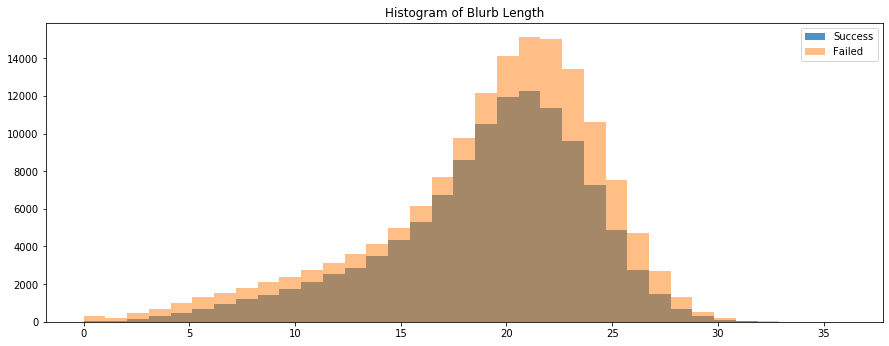

Success Descriptive Statistics
count   116077.00
mean        19.11
std          4.65
min          1.00
25%         17.00
50%         20.00
75%         22.00
max         35.00
Name: blurb_length, dtype: float64

Failed Descriptive Statistics
count   151602.00
mean        19.19
std          5.13
min          1.00
25%         17.00
50%         20.00
75%         23.00
max         36.00
Name: blurb_length, dtype: float64


In [222]:
fig=plt.figure(figsize=(15,5.5))
x = cleaned_data['blurb_length'].loc[cleaned_data['outcome'] == True]
y = cleaned_data['blurb_length'].loc[cleaned_data['outcome'] == False]
bins = np.linspace(0, 36, 36)

plt.hist(x, bins=bins, alpha=0.8, label='Success')
plt.hist(y, bins=bins, alpha=0.5, label='Failed')
plt.legend(loc='upper right')
plt.title('Histogram of Blurb Length')
plt.show()
print('\033[1m' + "Success Descriptive Statistics" + '\033[0m')
print(x.describe())
print('')
print('\033[1m' + "Failed Descriptive Statistics" + '\033[0m')
print(y.describe())

Both successful and unsuccessful projects have a similar blurb length distribution

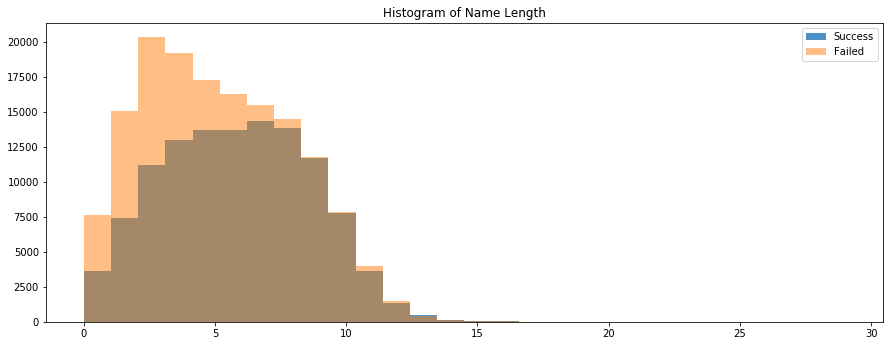

Success Descriptive Statistics
count   116077.00
mean         6.16
std          2.72
min          1.00
25%          4.00
50%          6.00
75%          8.00
max         27.00
Name: name_length, dtype: float64

Failed Descriptive Statistics
count   151602.00
mean         5.53
std          2.78
min          1.00
25%          3.00
50%          5.00
75%          8.00
max         29.00
Name: name_length, dtype: float64


In [223]:
fig=plt.figure(figsize=(15,5.5))
x = cleaned_data['name_length'].loc[cleaned_data['outcome'] == True]
y = cleaned_data['name_length'].loc[cleaned_data['outcome'] == False]
bins = np.linspace(0, 29, 29)
plt.hist(x, bins=bins, alpha=0.8, label='Success')
plt.hist(y, bins=bins, alpha=0.5, label='Failed')
plt.legend(loc='upper right')
plt.title('Histogram of Name Length')
plt.show()
print('\033[1m' + "Success Descriptive Statistics" + '\033[0m')
print(x.describe())
print('')
print('\033[1m' + "Failed Descriptive Statistics" + '\033[0m')
print(y.describe())

Longer blurbs were more likely to be successful on average. There is a high concentration of failures in the 1-4 name length range compared with the more uniform distribution of successes.

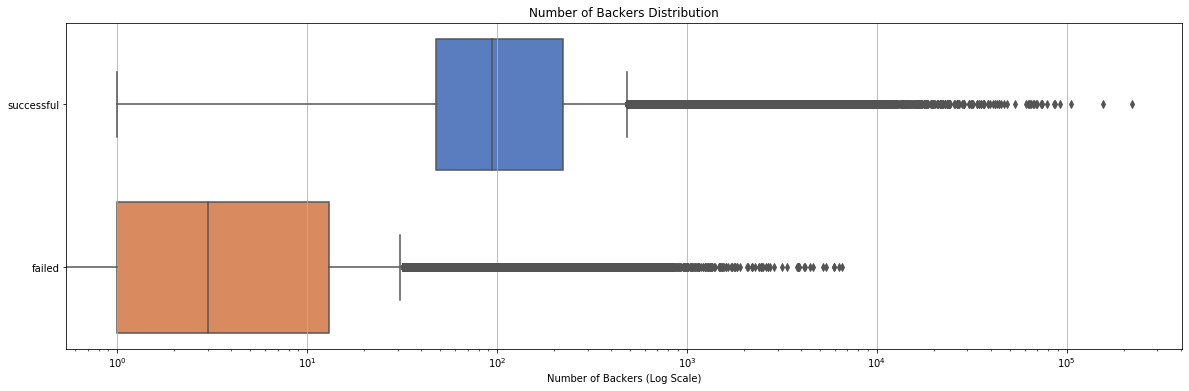

In [224]:
#looking distribution of the backers_count column
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xscale("log")
sns.boxplot(x="backers_count", y = 'binary_state', data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "Number of Backers (Log Scale)", title = 'Number of Backers Distribution')
plt.show()

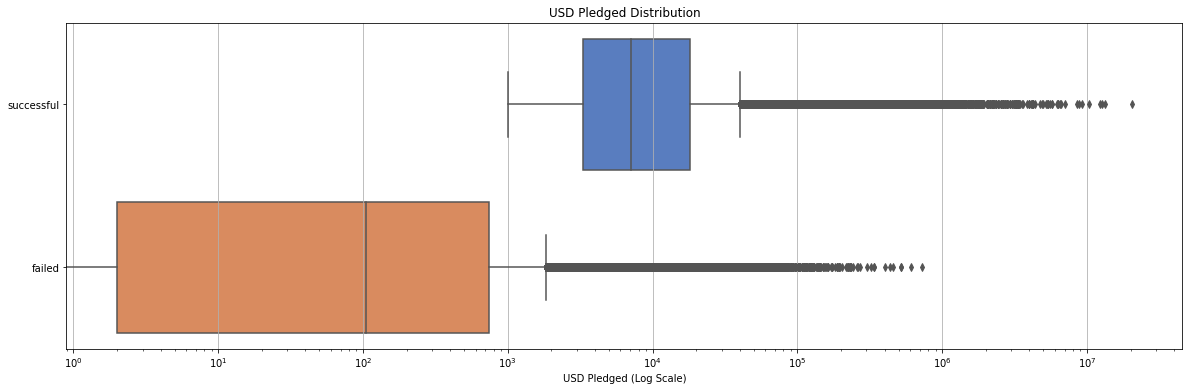

In [225]:
#looking at distribution of USD Pledged
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xscale("log")
sns.boxplot(x="usd_pledged", y="binary_state", data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "USD Pledged (Log Scale)", title = 'USD Pledged Distribution')
plt.show()

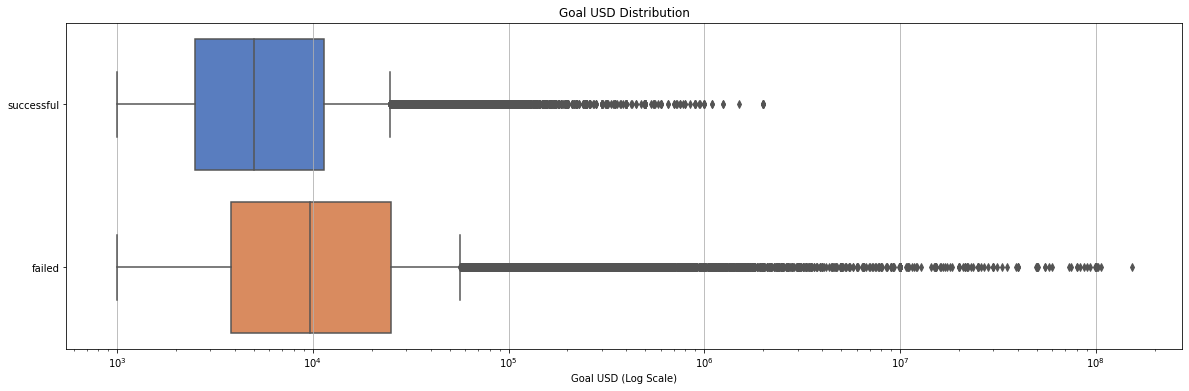

In [226]:
#looking at distribution of USD Goal
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xscale("log")
sns.boxplot(x="goal_USD", y="binary_state", data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "Goal USD (Log Scale)", title = 'Goal USD Distribution')
plt.show()

count   267679.00
mean         1.03
std          4.86
min          0.00
25%          0.01
50%          0.24
75%          1.11
max        926.57
Name: prop_goal, dtype: float64


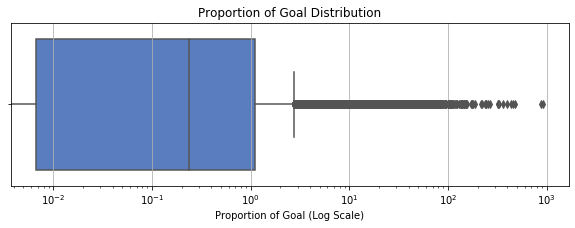

In [227]:
#look at proportion of goal column
print(cleaned_data.prop_goal.describe())

#looking distribution of the prop_goal column
f, ax = plt.subplots(figsize=(10, 3))
ax.set_xscale("log")
sns.boxplot(x="prop_goal", data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "Proportion of Goal (Log Scale)", title = 'Proportion of Goal Distribution')
plt.show()

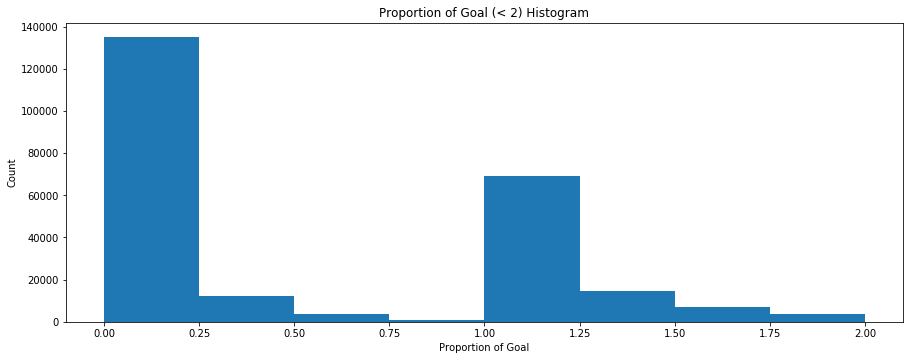

In [228]:
#histogram of Goal Distribution
fig=plt.figure(figsize=(15,5.5))
x = cleaned_data['prop_goal'].loc[cleaned_data['prop_goal'] < 2]
plt.hist(x, bins=8)
plt.xlabel('Proportion of Goal')
plt.ylabel('Count')
plt.title('Proportion of Goal (< 2) Histogram')
plt.show()

Projects usually do not get off the ground, but when they do, they tend to snowball just past the goal and then level off.

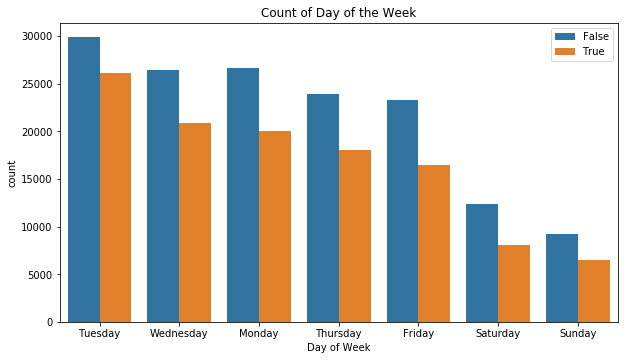

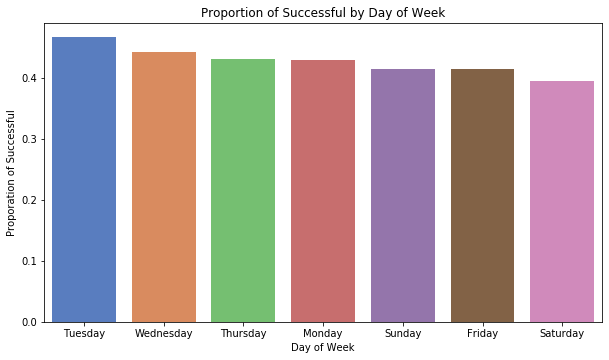

In [229]:
#day of the week bar chart
# https://seaborn.pydata.org/generated/seaborn.countplot.html interesting information
cleaned_data['day_week'] = cleaned_data['launched_at'].dt.day_name()
fig=plt.figure(figsize=(10,5.5))
chart = sns.countplot(x = 'day_week', hue = 'outcome', data = cleaned_data, order = cleaned_data['day_week'].value_counts().index)
plt.xlabel('Day of Week')
plt.legend(title = '')
plt.title('Count of Day of the Week')
plt.show()
#probability distribution
y = (cleaned_data['day_week'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['day_week'].value_counts())
y = y.sort_values(ascending=False)
fig=plt.figure(figsize=(10,5.5))
ax = sns.barplot(x = y.index, y = y, palette = 'muted')
plt.xlabel('Day of Week')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Day of Week')
plt.show()

The middle of the week is the most popular launch time and has the higest probability of success.

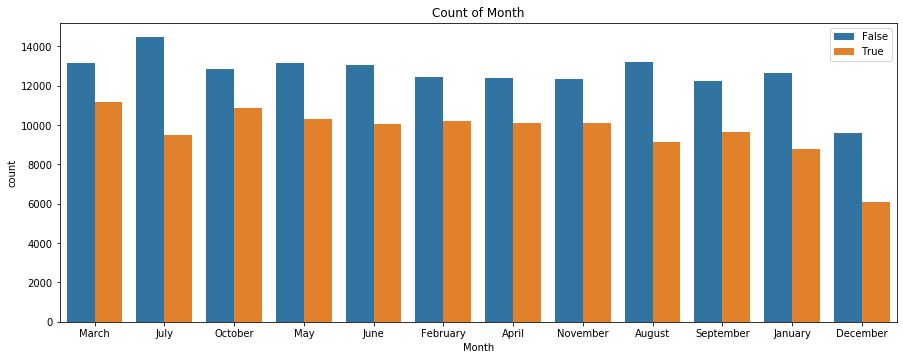

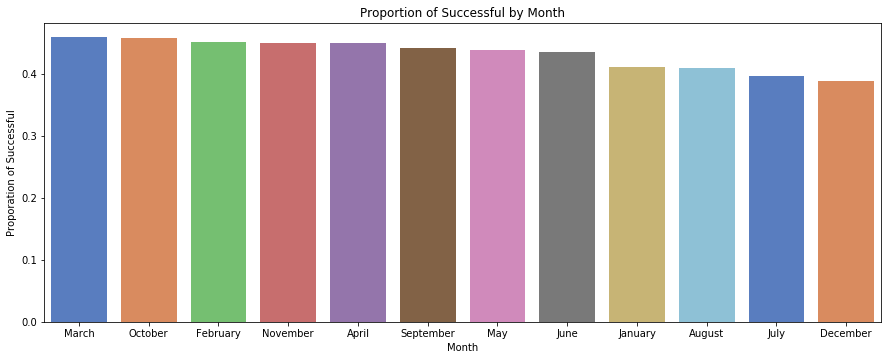

In [230]:
#month of launch count plot
cleaned_data['month'] = cleaned_data['launched_at'].dt.month_name()
fig=plt.figure(figsize=(15,5.5))
chart = sns.countplot(x = 'month', hue = 'outcome', data = cleaned_data, order = cleaned_data['month'].value_counts().index)
plt.xlabel('Month')
plt.legend(title = '')
plt.title('Count of Month')
plt.show()
y = (cleaned_data['month'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['month'].value_counts())
y = y.sort_values(ascending=False)
fig=plt.figure(figsize=(15,5.5))
ax = sns.barplot(x = y.index, y = y, palette = 'muted')
plt.xlabel('Month')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Month')
plt.show()

There was not huge variability between months; however, December has been down months all around.

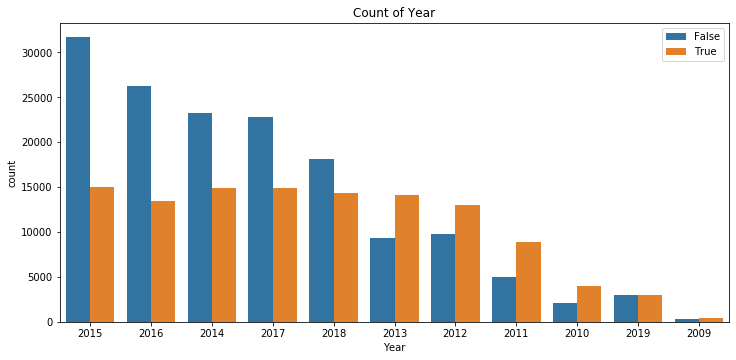

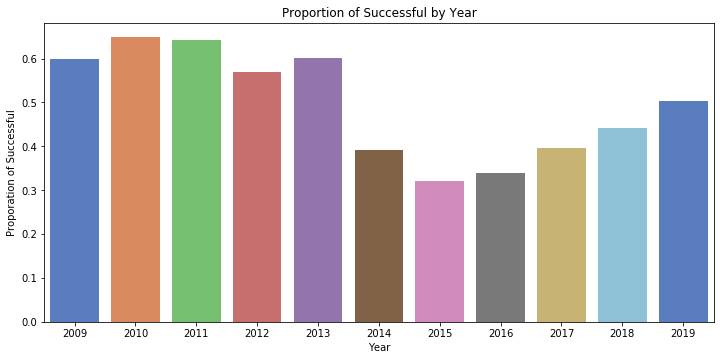

In [231]:
#year of launch count plot
cleaned_data['year'] = cleaned_data['launched_at'].dt.year
fig=plt.figure(figsize=(12,5.5))
chart = sns.countplot(x = 'year', hue = 'outcome', data = cleaned_data, order = cleaned_data['year'].value_counts().index)
plt.xlabel('Year')
plt.legend(title = '')
plt.title('Count of Year')
plt.show()
y = (cleaned_data['year'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['year'].value_counts())
fig=plt.figure(figsize=(12,5.5))
ax = sns.barplot(x = y.index, y = y, order = y.index, palette = 'muted')
plt.xlabel('Year')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Year')
plt.show()

Note that 2019 data is not for a full year. Has the success rate changed in a predicatible pattern?

It appear that the early years were most successful with a large drop in 2014 and then it eventually began to rebound.

**What happened in 2014?**

In [232]:
#work in progress to figure out what happened in 2014
print('\033[1m' + '2013' + '\033[0m')
print(cleaned_data[['backers_count', 'usd_pledged', 'goal_USD', 'prop_goal']].loc[cleaned_data['year'] == 2013].describe())
print('')
print('\033[1m' + '2014' + '\033[0m')
print(cleaned_data[['backers_count', 'usd_pledged', 'goal_USD', 'prop_goal']].loc[cleaned_data['year'] == 2014].describe())

2013
       backers_count  usd_pledged    goal_USD  prop_goal
count       23493.00     23493.00    23493.00   23493.00
mean          225.91     17235.88    25687.66       1.20
std          1304.08     93558.53   323337.36       2.98
min             0.00         0.00     1000.00       0.00
25%            11.00       535.00     3000.00       0.07
50%            50.00      3365.00     6000.00       1.03
75%           136.00     10360.00    15000.00       1.21
max         91585.00   5702153.38 31424010.40     106.08

2014
       backers_count  usd_pledged     goal_USD  prop_goal
count       38173.00     38173.00     38173.00   38173.00
mean          135.38     11524.35     50608.01       0.83
std           876.57     99827.00   1067704.99       3.44
min             0.00         0.00      1000.00       0.00
25%             2.00        34.07      3000.00       0.00
50%            17.00      1112.54      7500.00       0.14
75%            80.00      6276.00     20000.00       1.08
max        1

In [233]:
print('The total number of backers in 2013 was ' + str(cleaned_data.backers_count.loc[cleaned_data['year'] == 2013].sum()) + '.')
print('')
print('The total number of backers in 2014 was ' + str(cleaned_data.backers_count.loc[cleaned_data['year'] == 2014].sum()) + '.')

The total number of backers in 2013 was 5307192.

The total number of backers in 2014 was 5167952.


Activity for project creation spiked in 2014, but the number of backers actually decreased. The mean target goal in USD nearly doubled. Why?

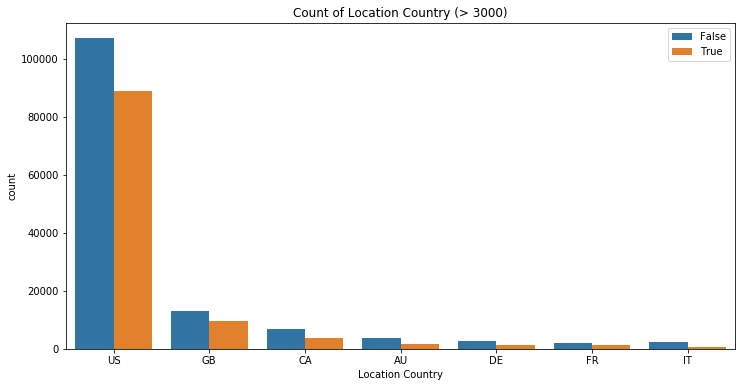

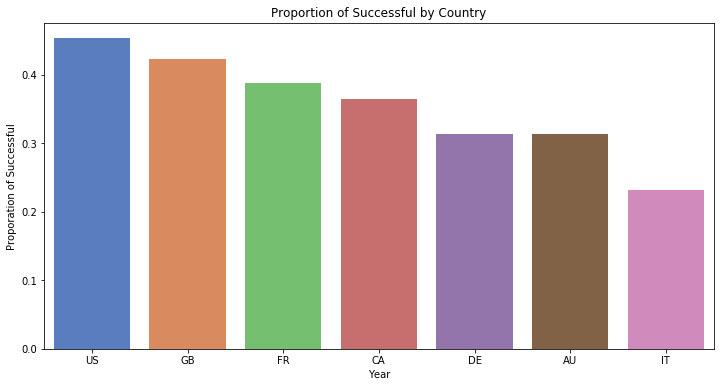

US   0.45
GB   0.42
FR   0.39
CA   0.36
DE   0.31
AU   0.31
IT   0.23
Name: location_country, dtype: float64


In [234]:
#show the frequency of location country for those with at least 3000 occurrences
fig = plt.figure(figsize = (12, 6))
sns.countplot(x = 'location_country', hue = 'outcome', 
              data = cleaned_data[cleaned_data.location_country.isin(['US', 'GB', 'CA', 'AU', 'DE', 'FR', 'IT'])], 
              order = cleaned_data.location_country.loc[cleaned_data.location_country.isin(['US', 'GB', 'CA', 'AU', 'DE', 'FR', 'IT'])].value_counts().index)
plt.legend(title ='')
plt.xlabel('Location Country')
plt.title('Count of Location Country (> 3000)')
plt.show()
# make this into a probability distribution like above
y = (cleaned_data['location_country'].loc[cleaned_data['location_country'].isin(['US', 'GB', 'CA', 'AU', 'DE', 'FR', 'IT'])].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['location_country'].loc[cleaned_data['location_country'].isin(['US', 'GB', 'CA', 'AU', 'DE', 'FR', 'IT'])].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order = y.index, palette = 'muted')
plt.xlabel('Year')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Country')
plt.show()
print(y)

There are only seven countries with more than 3000 occurrences. The US dominates with Great Britain and Canada coming in second and third.

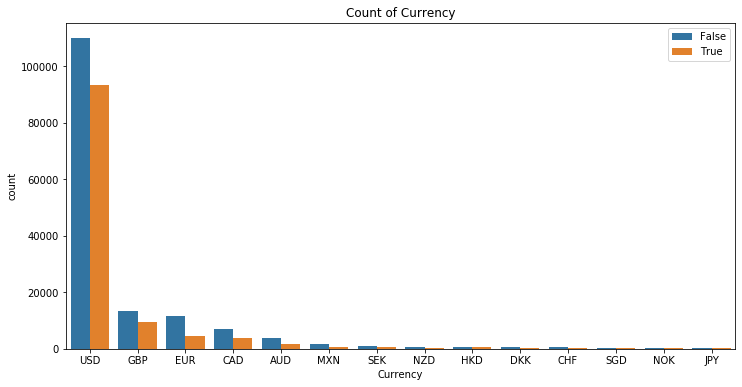

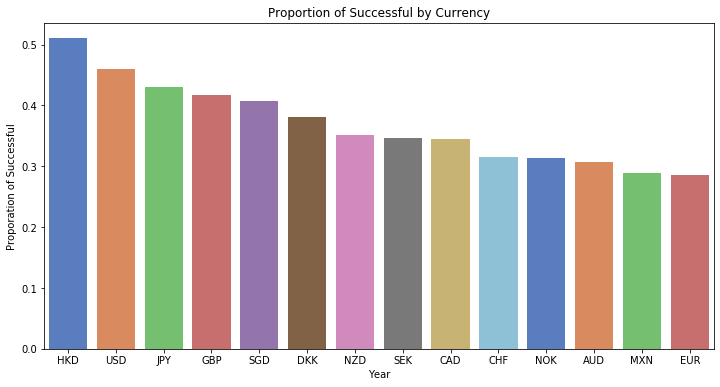

HKD   0.51
USD   0.46
JPY   0.43
GBP   0.42
SGD   0.41
DKK   0.38
NZD   0.35
SEK   0.35
CAD   0.34
CHF   0.32
NOK   0.31
AUD   0.31
MXN   0.29
EUR   0.28
Name: currency, dtype: float64


In [235]:
#show the frequency of currency
fig = plt.figure(figsize = (12, 6))
sns.countplot(x = 'currency', hue = 'outcome', 
              data = cleaned_data,
              order = cleaned_data.currency.value_counts().index)
plt.legend(title ='')
plt.xlabel('Currency')
plt.title('Count of Currency')
plt.show()
# make this into a probability distribution like above
y = (cleaned_data['currency'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['currency'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order = y.index, palette = 'muted')
plt.xlabel('Year')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Currency')
plt.show()
print(y)

The USD dominates in frecuency and it's probabiliy is similar to the overall population probability.

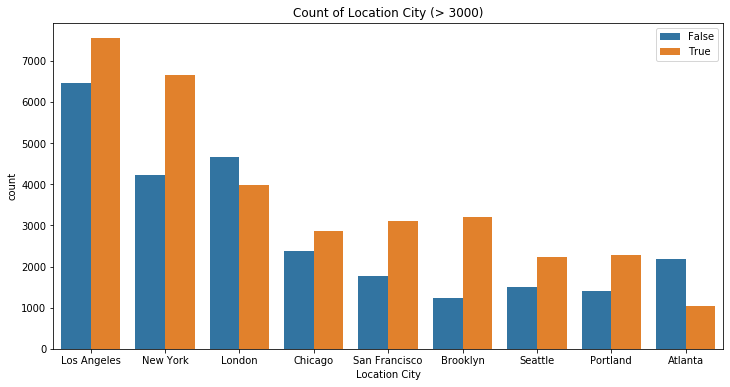

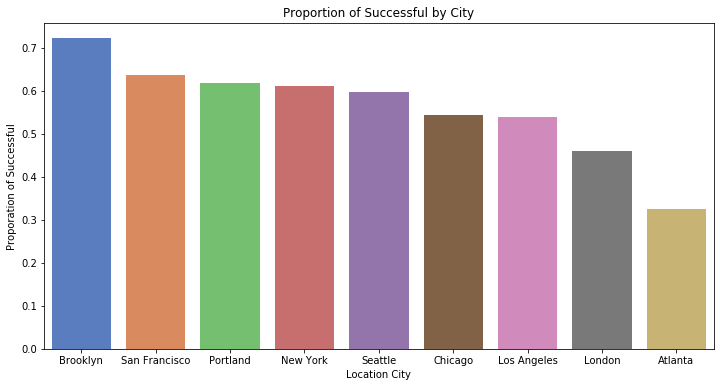

Brooklyn        0.72
San Francisco   0.64
Portland        0.62
New York        0.61
Seattle         0.60
Chicago         0.54
Los Angeles     0.54
London          0.46
Atlanta         0.32
Name: city, dtype: float64


In [236]:
#show the frequency of location city for those with at least 3000 instances
fig = plt.figure(figsize = (12, 6))
sns.countplot(x = 'city', hue = 'outcome', 
              data = cleaned_data,
              order = cleaned_data.city.value_counts().head(9).index)
plt.legend(title ='')
plt.xlabel('Location City')
plt.title('Count of Location City (> 3000)')
plt.show()
# make this into a probability distribution like above
y = (cleaned_data['city'].loc[cleaned_data['city'].isin(cleaned_data.city.value_counts().head(9).index)].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['city'].loc[cleaned_data['city'].isin(cleaned_data.city.value_counts().head(9).index)].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order = y.index, palette = 'muted')
plt.xlabel('Location City')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by City')
plt.show()
print(y)

The major US cities for launch were more successful than average except for Atlanta which was well below average. This is perhaps a proxy for income or disposable income. London came in slightly above average, but was probably hurt by not being in the US. Brooklyn is the Kickstarter headquarters.

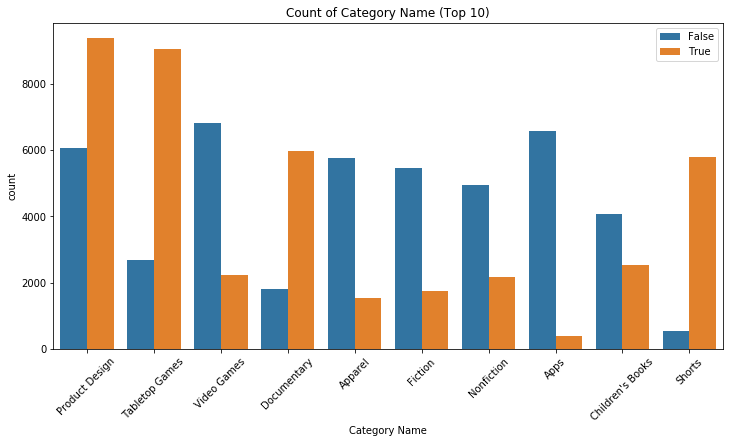

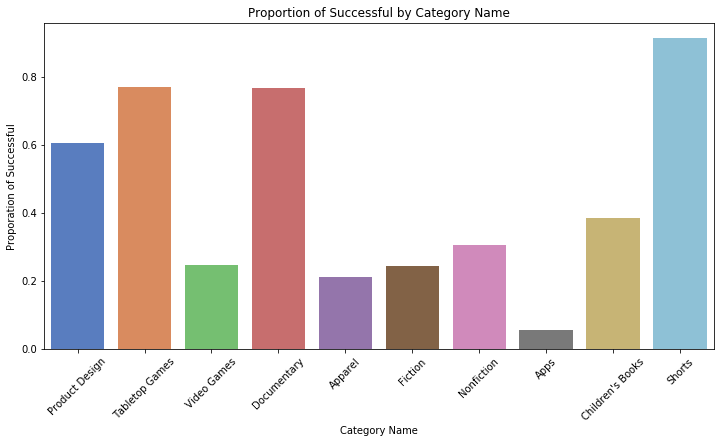

In [237]:
fig = plt.figure(figsize = (12, 6))
chart = sns.countplot(x = 'category_name', hue = 'outcome', data = cleaned_data, order=cleaned_data.category_name.value_counts().iloc[:10].index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.legend(title ='')
plt.xlabel('Category Name')
plt.title("Count of Category Name (Top 10)")
plt.show()
#probability distribution
y = (cleaned_data['category_name'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['category_name'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order=cleaned_data.category_name.value_counts().iloc[:10].index, palette = 'muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('Category Name')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Category Name')
plt.show()

There are very high variability between categories with Apps being extremely unsuccessful and shorts (clothing) being very successful.

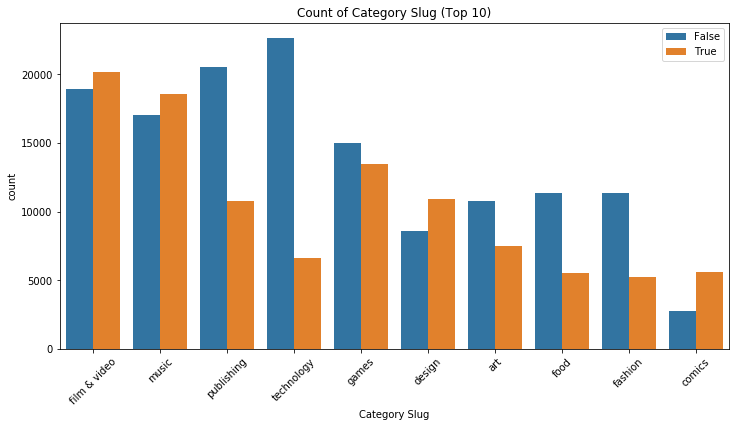

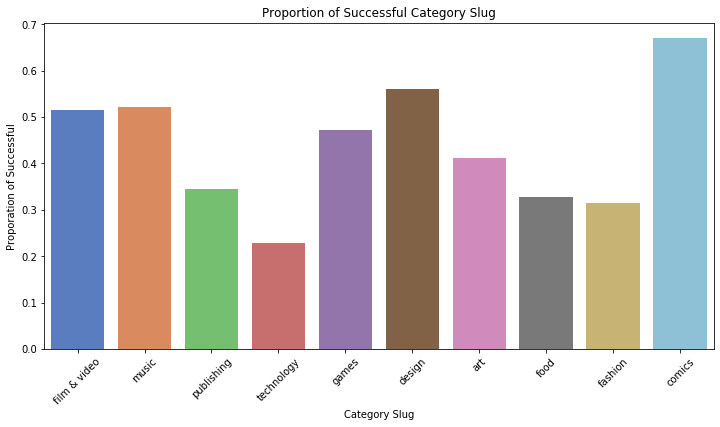

In [238]:
fig = plt.figure(figsize = (12, 6))
chart = sns.countplot(x = 'category_slug', hue = 'outcome', data = cleaned_data, order=cleaned_data.category_slug.value_counts().iloc[:10].index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.legend(title ='')
plt.xlabel('Category Slug')
plt.title("Count of Category Slug (Top 10)")
plt.show()

#probability distribution
y = (cleaned_data['category_slug'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['category_slug'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order=cleaned_data.category_slug.value_counts().iloc[:10].index, palette = 'muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('Category Slug')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful Category Slug')
plt.show()

Category slug may be more informative than category name due to the high variablity in the later column.

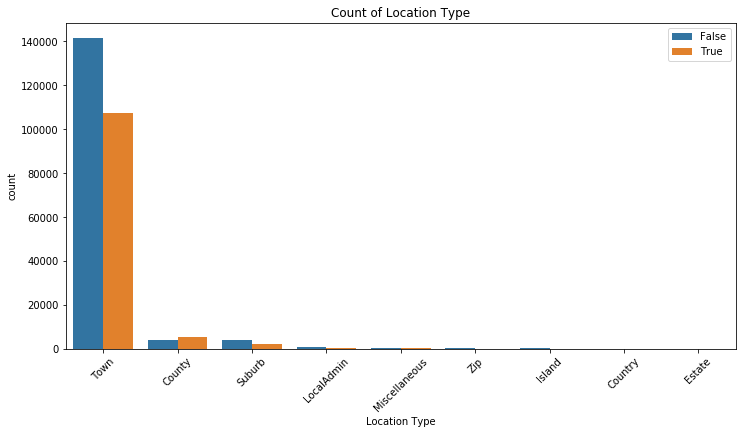

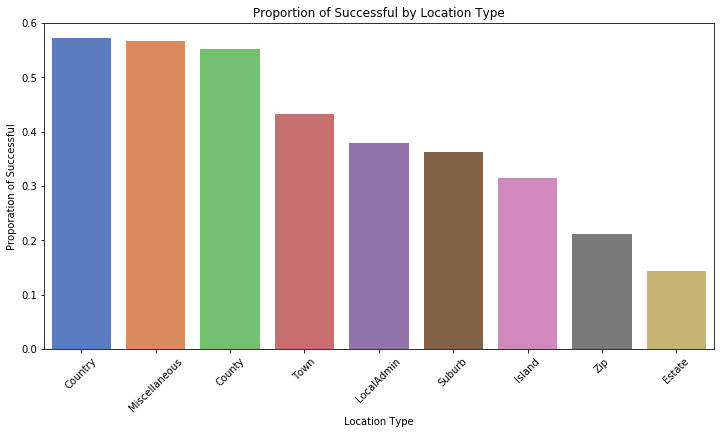

In [239]:
fig = plt.figure(figsize = (12, 6))
chart = sns.countplot(x = 'location_type', hue = 'outcome', data = cleaned_data, order=cleaned_data.location_type.value_counts().index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.legend(title ='')
plt.xlabel('Location Type')
plt.title("Count of Location Type")
plt.show()

#probability distribution
y = (cleaned_data['location_type'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['location_type'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order=y.index, palette = 'muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('Location Type')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Location Type')
plt.show()

In [240]:
#too much concentration in town for the data to be useful?
print(cleaned_data.location_type.value_counts())

Town             248723
County             9464
Suburb             6276
LocalAdmin         1341
Miscellaneous       921
Zip                 567
Island              359
Country              21
Estate                7
Name: location_type, dtype: int64


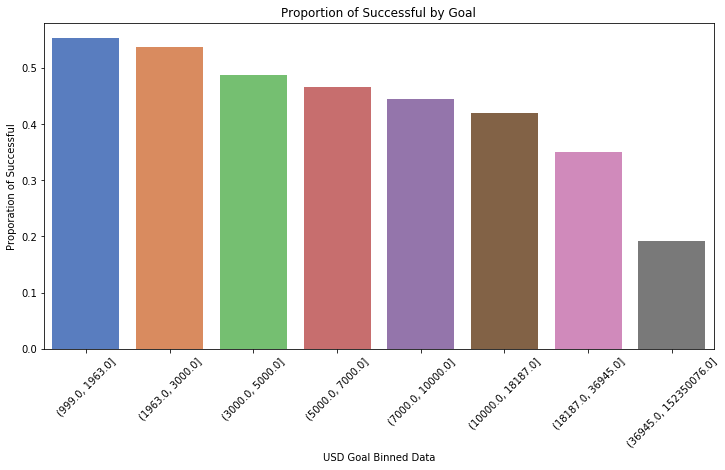

In [241]:
#binning the data to look at probabilities by goal USD
cleaned_data['qcut_goal'] = pd.qcut(cleaned_data['goal_USD'], q=8, precision = 0)
#probability distribution
y = (cleaned_data['qcut_goal'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['qcut_goal'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order=y.index, palette = 'muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('USD Goal Binned Data')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Goal')
plt.show()

As expected, probability declines with increasing USD goal amount.

(0.9999, 1.0001]    203039
(1.0001, 1.3]        20855
(1.3, 10.0]          19064
(0.755, 0.9999]      12613
(0.0, 0.755]         12108
Name: cut_static_rate, dtype: int64


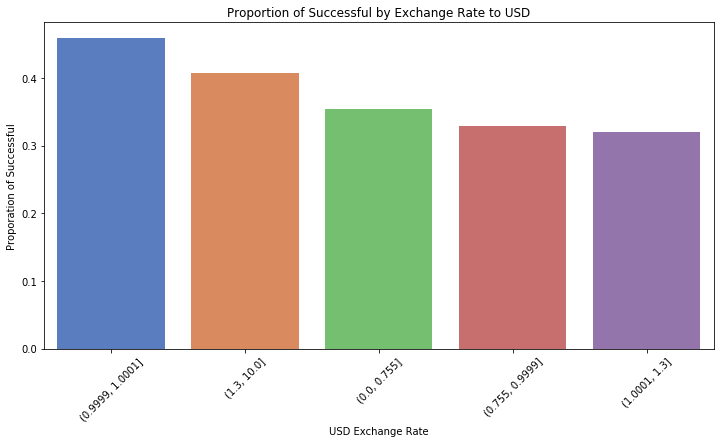

In [242]:
cleaned_data['cut_static_rate'] = pd.cut(cleaned_data['static_usd_rate'], [0,0.755, 0.9999,1.0001, 1.3, 10])
print(cleaned_data.cut_static_rate.value_counts())
#probability distribution
y = (cleaned_data['cut_static_rate'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['cut_static_rate'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order=y.index, palette = 'muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('USD Exchange Rate')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Exchange Rate to USD')
plt.show()

Items listed in USD had the highest probability of success. There were mixed results for other currency, but the most valueable currency column did the second best. There will likely be heavy correlation with location_country. However, it won't be perfect as exchange rates change and not all US projects were listed in USD.